In [3]:
from numpy import *
%pylab inline
style.use('bmh')
bmhcols=['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

Populating the interactive namespace from numpy and matplotlib


In [16]:
L = 1e-3 #12e-3 #Henry, inductance
R = 6. #Ohms, resistance
V_supply = 12. #volts, supply
#V_diode = 1 #volts, recirculation diode drop
I = 1. #amp, current control set point
I_hysteresis = .05 #amps, hysteresis in chopper drive
duty = I * R / V_supply #duty cycle, assuming no current recirculation
per_switch = I_hysteresis * L / V_supply #time to switch


f_clk = 32e6 #clock frequency
per_clk = 1/f_clk #clock tick period
#print "ticks per time constant: %d"%(tau / per_clk)
#print "ticks per milli time constant: %d"%(1e-3 * tau / per_clk)

print 1e6*per_switch
print "ticks per switch: ", per_switch / per_clk
#f_switch = #switching frequency, based on hysteresis


print duty
tau = L/R


4.16666666667
ticks per switch:  133.333333333
0.5


In [15]:
V_in = 390e-3/2 #V, input signal amplitude
V_out = 340e-3/2 #V, voltage across resistor
R_test = 11 #ohms
#R_function = 50 #ohms, function generator

I = V_out / (R_test) #V/R=I
R_motor = V_in/I - R_test #V/I=R
f_test = 1000 #Hz, inductance test freq
print "motor resistance: %.2f Ohms"%R_motor
Z = = sqrt( R**2 +  ) 
L = X / (2*pi*f_test)


motor resistance: 1.62 Ohms


* goals
    * servo control of stepper motors. Need position feedback with ~100 counts per pole pair.  This is 20000 ticks.  That's a high resolution encoder, but not ridiculous (only 14 bits, which is in the range of cheap magnetic encoders)

    * Nanotec video of sensorless control


* techniques
    * sensorless: kalman filter on back emf.  Hard to measure while not moving, but kalman filter can help.
    * sensorless: measure reluctance (variable inductance).  Hybrid motors don't actually vary inductance very much!
    * magnetic encoder on diametrically magnetized shaft magnet: AMS 5053... lowish latency errors.  expensive.  
        * mechaduino project
    * magnetic encoder with a codewheel.  Means you can use a lower resolution linear magnetic encoder (lower latency?), but you need to buy/make and mount a codewheel.
    * mosolver
    * capacitive encoder  

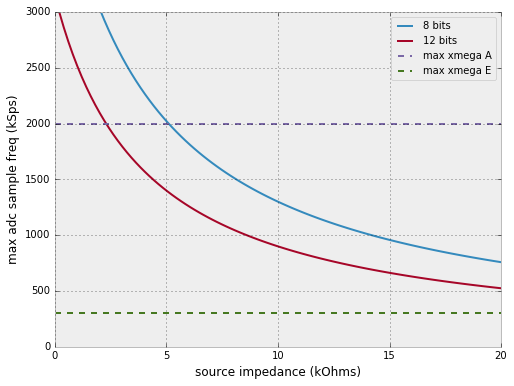

In [120]:
def max_adc_sample_freq(R_source,C_sample=4.4e-12,R_channel=4.0e3,bits=8):
    #defaults from http://www.atmel.com/images/Atmel-8387-8-and16-bit-AVR-Microcontroller-XMEGA-A4U_Datasheet.pdf
    return 1/( 2*(R_source+R_channel)*C_sample*log(2**(bits+1)) )

r_source = linspace(1,2e4,100)
figure(figsize=(8,6), dpi=600)

plot( 1e-3*r_source, 1e-3*max_adc_sample_freq(r_source,bits=8), label='8 bits' )
plot( 1e-3*r_source, 1e-3*max_adc_sample_freq(r_source,bits=12), label='12 bits' )
plot( 1e-3*r_source, 2e3*ones_like(r_source), ls='--',label='max xmega A')
plot( 1e-3*r_source, 300*ones_like(r_source), ls='--',label='max xmega E')
ylim(1,3000)
#yscale('log')
ylabel( 'max adc sample freq (kSps)')
xlabel( 'source impedance (kOhms)')
legend(loc='upper right',prop={'size':10})

In [72]:
#from Field Oriented Sensorless Position Control of a Hybrid Stepper Motor with Extended Kalman Filter
x_error = .0004 #radians
steps = 200
error_per_step = (2*pi/steps)/x_error
print error_per_step

78.5398163397


In [74]:
#calculating current for 50% forward, 50% backwards voltage swing over inductive load.

print 1/.000005


def I(t,V_previous, V_step, R, L):
    return (V_previous / R) + ( (V_step - V_previous)/R )*(1 - exp(-t*R/L))
R_load = 1 #Ohms
L_load = 2.5e-3 #Henries
f = 1e3 #Hz
V = 12 #volts
per = 1/f
n_cycles = 10
res = 100
t = linspace( 0, per*n_cycles, res*n_cycles*2 )
Is = [0]
for i in range(n_cycles):
    ti = linspace(0,per/2, res)
    Is += list(I(ti,Is[-1],V, R_load, L_load   ))
    Is += list(I(ti,V,-V, R_load, L_load   ))
#plot( t, asarray(Is))

200000.0


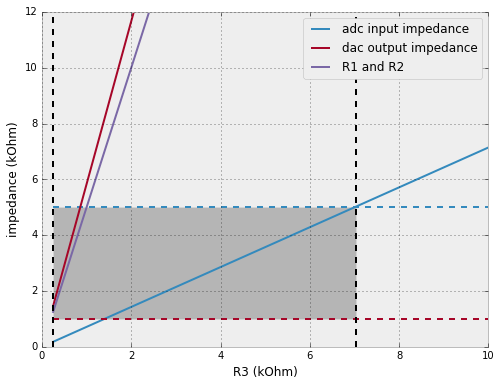

In [119]:
#resistor network
def adc_input_impedance( R1, R2, R3 ):
    return 1 / (1/R1 + 1/R2 + 1/R3)
def dac_output_impedance( R1, R2, R3 ):
    return R1 + 1/(1/R3 + 1/R2)
def R1( v_min_bipolar, R3 ):
    #assume 1V reference at top of network
    return -R3/v_min_bipolar
def R2( v_max_bipolar, R3 ):
    #assume 1V reference at top of network
    return R3/v_max_bipolar
v_min,v_max = -.2,.2 # -.2V to .2V bipolar scale to 0V to 1V unipolar
R3 = linspace(.25, 10, 100)
max_adc_input_impedance = 5 #kOhm
min_dac_output_impedance = 1 #kOhm
adc_imp = adc_input_impedance( R1(v_min,R3), R2(v_max,R3), R3 )
dac_imp = dac_output_impedance( R1(v_min,R3), R2(v_max,R3), R3 )

figure(figsize=(8,6), dpi=600)
plot( R3, adc_imp, label='adc input impedance', c=bmhcols[0] )
plot( R3, max_adc_input_impedance*ones_like(adc_imp), c=bmhcols[0], ls='--')
plot( R3, dac_imp, label='dac output impedance', c=bmhcols[1])
plot( R3, min_dac_output_impedance*ones_like(R3), c=bmhcols[1], ls='--')
plot( R3, R1(v_min,R3), label='R1 and R2', c=bmhcols[2])
upper_ind = where(adc_imp>max_adc_input_impedance)[0][0]
lower_ind = where(dac_imp>min_dac_output_impedance)[0][0]
plot( [R3[upper_ind],R3[upper_ind]], [0,12], c='k', ls='--' )
plot( [R3[lower_ind],R3[lower_ind]], [0,12], c='k', ls='--' )
fill_between([R3[lower_ind],R3[upper_ind]], 
             [max_adc_input_impedance,max_adc_input_impedance],[min_dac_output_impedance,min_dac_output_impedance],
            facecolor=(.2,.2,.2),alpha=.3)
xlim(0,amax(R3))
ylim(0,12)
xlabel( 'R3 (kOhm)')
ylabel( 'impedance (kOhm)')
legend(loc='upper right')

In [18]:
#XMega E vs. A on adc freq w gain
#from E manual: Down to 2.3 μs conversion time with 8-bit resolution and Down to 3.35μs conversion time with 12-bit resolution
#from E datasheet (table 36-8): ADC Clock frequency, Maximum is 1/4 of Peripheral clock, 1.8 MHz
def sample_rate_adc_e(f_adc,bits,sampval,gainfac):
    #f_adc: adc frequency
    #bits: resolution, 8 or 12
    #sampval: sampling time, for higher input impedance
    #gainfac: gain factor,  0 (1x gain), 1 (1/2x, 2x, 4x gain), 3 (32x, 64x gain)
    return f_adc / ( .5*(bits+sampval) + gainfac )
#A series is pipelined, which increases throughput, even though single signal propogation appears to be similar to the E series.
#can we use the 4 channels of the A to do two samples on two channels?

print "Max sample rate E-series, 12 bits, no gain: %d ksps"%(sample_rate_adc_e( 1.8e6, 12, 0, 0 )/1e3)
print "Max sample rate E-series, 12 bits, 4x gain: %d ksps"%(sample_rate_adc_e( 1.8e6, 12, 0, 1 )/1e3)
print "Max sample rate E-series, 8 bits, no gain: %d ksps"%(sample_rate_adc_e( 1.8e6, 8, 0, 0 )/1e3)
print "Max sample rate E-series, 8 bits, 4x gain: %d ksps"%(sample_rate_adc_e( 1.8e6, 8, 0, 1 )/1e3)


Max sample rate E-series, 12 bits, no gain: 300 ksps
Max sample rate E-series, 12 bits, 4x gain: 257 ksps
Max sample rate E-series, 8 bits, no gain: 450 ksps
Max sample rate E-series, 8 bits, 4x gain: 360 ksps


### Kneppo parameterization of BH Curve

In [4]:
def B_kneppo(H, B_s, H_m):
    #Kneppo parameterization of BH curve
    #B_s: saturation induction
    #H_m: field at which permeability is at max
    #http://www.tandfonline.com/doi/pdf/10.1080/02780898908952950
    #
    return B_s*exp( -H_m / H )

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in divide


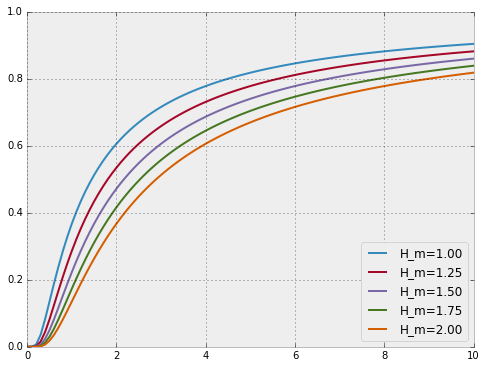

In [13]:
figure(figsize=(8,6))
H = linspace(0,10,101)
for H_m in linspace(1,2,5):
    plot( H, B_kneppo( H, 1, H_m), label='H_m=%.2f'%H_m )
legend(loc='lower right')

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in divide


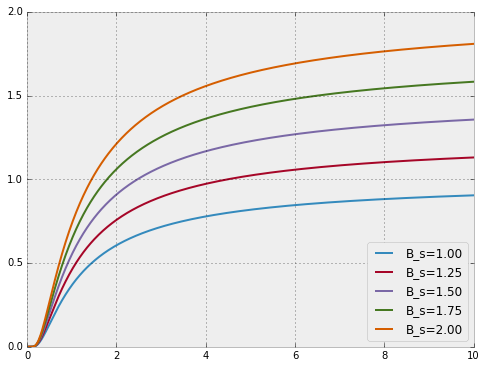

In [15]:
figure(figsize=(8,6))
H = linspace(0,10,501)
for B_s in linspace(1,2,5):
    plot( H, B_kneppo( H, B_s, 1), label='B_s=%.2f'%B_s )
legend(loc='lower right')